# Explore longterm data download as option

In [1]:
import obspy
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt 
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
fn = '/home/jhrag/data/1month.miniseed'
stream = obspy.read(fn)

In [5]:
stream

5 Trace(s) in Stream:
OO.AXEC2..HDH | 2021-10-01T00:00:00.000000Z - 2021-10-05T13:37:03.890644Z | 200.0 Hz, 78924743 samples
OO.AXEC2..HDH | 2021-10-06T20:16:19.000000Z - 2021-10-06T20:19:00.665000Z | 200.0 Hz, 32334 samples
OO.AXEC2..HDH | 2021-10-06T20:19:05.000000Z - 2021-10-09T14:33:24.935000Z | 200.0 Hz, 47691988 samples
OO.AXEC2..HDH | 2021-10-09T20:33:24.490000Z - 2021-10-30T17:43:21.162649Z | 200.0 Hz, 360839308 samples
OO.AXEC2..HDH | 2021-10-30T22:43:21.020000Z - 2021-11-01T00:00:00.000000Z | 200.0 Hz, 18199797 samples

## Build Custom Merge Function

In [11]:
t = []
data = []

for k, trace in enumerate(tqdm(stream)):
    
    if k != 0:
        # add nan value to begining
        t.append(np.array([trace.stats.starttime.ns - trace.stats.delta*1e9]).astype(int))
        data.append(np.array([np.nan]).astype(np.float32))
        
    # Add data (microsecond added to end time for rounding errors)
    t.append(np.arange(trace.stats.starttime.ns, trace.stats.endtime.ns + 1000, trace.stats.delta*1e9).astype(int))
    data.append(trace.data.astype(np.float32))
    
    if k != (len(stream)-1):
        # add nan value to end
        t.append(np.array([t[-1][-1] + trace.stats.delta*1e9]).astype(int))
        data.append(np.array([np.nan]).astype(np.float32))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


In [12]:
data = np.concatenate(data)
t = np.concatenate(t)

In [ ]:
f = interp1d(t,data, kind='cubic', bounds_error=False)

In [13]:
starttime = pd.Timestamp('2021-10-1')
endtime = pd.Timestamp('2021-11-1')

time_grid = np.arange(
    starttime.value,
    endtime.value,
    1/200*1e9
)

In [15]:
interpolated_data = f(time_grid)

/Users/jhrag/opt/anaconda3/envs/ooi_dev9/lib/python3.9/site-packages/scipy/interpolate/interpolate.py:630: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


ValueError: A value in x_new is above the interpolation range.

## Explore how interpolation works

In [24]:
t = np.arange(0,1,0.005)
x = np.sin(2*np.pi*2*t)

In [26]:
x[50:100] = np.nan

In [32]:
f = interp1d(t,x, bounds_error=False)

In [29]:
t2 = np.arange(0,1,0.001)

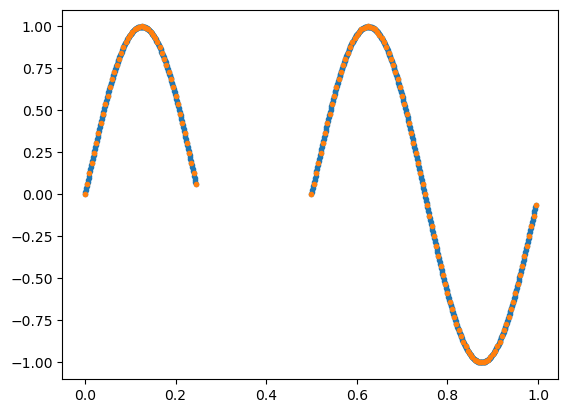

In [37]:
plt.plot(t2, f(t2), '.')
plt.plot(t, x, '.')